In [1]:
from active_optics_init import *

>>> ON_AXIS_SRC.json
>>> ATMOSPHERE.json
>>> WFS_GUIDE_STARS.json
>>> WFS.json
>>> ON_AXIS_IMGR.json
>>> TT7_GUIDE_STAR.json
>>> TT7.json
>>> GMT.json
WFS seeing: 0.75arcsec
WFS FWHM: 5.000000 pixel
6912
detector resolution: 384pixel
WFS pixel scale:  0.42arcsec
WFS field-of-view 3.33arcsec


In [22]:
from LinearActiveOptics import BuildLinearActiveOptics, Wavefronts, \
                ModelData, LinearActiveOptics, noiseRejectionFactor, wfsNoise

In [3]:
laco = LinearActiveOptics('ActiveOptics_27BM','DATA/onAxisWavefront_401')

(14, 39)
(14, 37)
@(CalibrationMatrix)> Updating the pseudo-inverse...
[2, 2, 2, 2, 2, 2, 0]


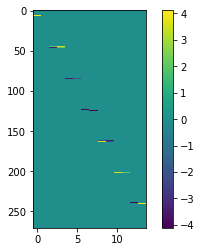

In [4]:
J = laco._s_Mtt7.todense()
plt.imshow(J,aspect=0.1)
plt.colorbar()

233.454906132


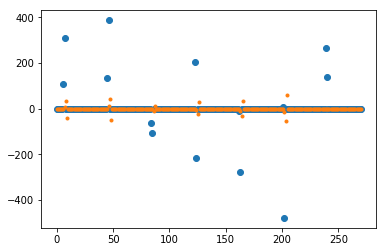

In [5]:
v = J.dot(np.random.randn(14,1))*56#*ceo.constants.MAS2RAD
plt.plot(v,'o')
print np.std(v[v!=0])
w = laco._s_Qwfs.dot(v)
plt.plot(w,'.')

In [6]:
np.std(laco.W.dot(v*ceo.constants.MAS2RAD))*1e6

0.80870694524826459

In [7]:
np.std(laco.W.dot(w*ceo.constants.MAS2RAD))*1e6

2.5194278749386046e-07

## Wavefront samples

In [8]:
nrf = noiseRejectionFactor({'T':5e-3,'tau':5e-3,'g':0.5})
print nrf

0.538576520298


In [31]:
print tt7_prms
print tt7_guide_star

{'N_PX_IMAGE': 710, 'photoElectronGain': 0.66, 'N_PX_LENSLET': 1023, 'readOutNoiseRms': 0.5, 'BIN_IMAGE': 142, 'd': 25.5}
{'rays_origin': [0, 0, 25], 'magnitude': 14, 'zenith': 0.0017453292519943294, 'azimuth': 3.141592653589793, 'photometric_band': 'R+I', 'rays_box_sampling': 1024, 'fwhm': 0, 'rays_box_size': 25.5, 'height': inf}


In [99]:
#if TT7_CLASS=='TT7':
r0 = 16e-2
print "r0=%.2f @ %fnm"%(r0*1e2,r0_wavelength*1e9)
tt7 = ceo.TT7(**tt7_prms)
_r0_ = r0*(tt7_gs.wavelength/r0_wavelength)**1.2
seeingArcsec = tt7_gs.wavelength/_r0_*ceo.constants.RAD2ARCSEC
print "TT7 seeing: %.2farcsec"%seeingArcsec
pxscl = tt7.camera.pixelScaleArcsec(tt7_gs)
tt7_gs_fwhm = round(seeingArcsec/(pxscl/tt7.BIN_IMAGE))
print "WFS FWHM: %d pixel"%tt7_gs_fwhm
tt7_gs.fwhm = tt7_gs_fwhm

print "detector resolution: %dpixel"%tt7.N_PX_FRAME
print "WFS pixel scale:  %.2farcsec"%pxscl
print "WFS field-of-view %.2farcsec"%(pxscl*tt7.N_PX_IMAGE/tt7.BIN_IMAGE)

r0=16.00 @ 500.000000nm
TT7 seeing: 0.60arcsec
WFS FWHM: 208 pixel
detector resolution: 5pixel
WFS pixel scale:  0.41arcsec
WFS field-of-view 2.05arcsec


In [94]:
tt7_gs.magnitude = [16.5]
nPhLenslet = tt7_gs.nPhoton*tt7_prms['photoElectronGain']
print "Number of photon-electron: %.0f for magnitude %.1f in band %s"%(nPhLenslet,tt7_gs.magnitude,tt7_gs.band)
nPxLenslet = np.floor(15/pxscl)
print "%d pixels accross the 15arcsec fov"%nPxLenslet

Number of photon-electron: 4055 for magnitude 16.5 in band R+I
36 pixels accross the 15arcsec fov


In [101]:
sig2_noise = wfsNoise(nPhLenslet,seeingArcsec,pxscl,nPxLenslet,tt7_prms['readOutNoiseRms'],
                      controller={'T':5e-3,'tau':5e-3,'g':0.5})
print "Centroid error RMS: %.3fmas"%(np.sqrt(sig2_noise)*ceo.constants.RAD2MAS)

@(wfsNoise)> Closed-loop noise rejection factor: 0.5386
Centroid error RMS: 15.091mas


In [81]:
(F,rmsF) = laco.wavefrontSamples(N_SAMPLE=100,tt7_rms=np.sqrt(sig2_noise))
#(F,rmsF) = laco.wavefrontSamples(N_SAMPLE=100,wfs_rms=60*ceo.constants.MAS2RAD)

In [82]:
F.shape

(401, 401, 100)

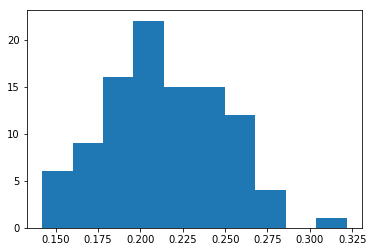

In [83]:
plt.hist(rmsF*1e6);

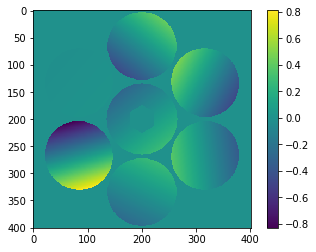

In [84]:
plt.imshow(F[:,:,0]*1e6)
plt.colorbar()

In [85]:
from scipy.signal import fftconvolve
from scipy.special import gamma, kv

def atmSF(_rho_,_r0_,_L0_):
    c = 2*gamma(11./6.)*(24.*gamma(6./5.)/5.)**(5./6.)/(2**(5./6.)*np.pi**(8./3.))
    red = np.asarray(2*np.pi*_rho_/_L0_)
    out = np.zeros(red.shape)
    idx = red!=0
    redd = red[idx]
    out[idx] = c*(_L0_/_r0_)**(5./3.)*(gamma(5./6.)/2**(1./6.) - redd**(5./6.)*kv(5./6.,redd))
    return out

def atmOTF(_rho_,_r0_,_L0_):
    return np.exp(-0.5*atmSF(_rho_,_r0_,_L0_))

In [86]:
def telOTF(A,F,wavelength):
    k = 2.*np.pi/wavelength
    W = A*np.exp(1j*k*F)  
    v = np.sum(A)
    S1 = np.fliplr(np.flipud(W))
    S2 = np.conj(W)
    AW = fftconvolve(S1,S2)
    return AW

In [87]:
def PSSn(A,F,L=25.5,wavelength=500e-9,r0=15e-2,L0=25):
    nPx = A.shape[0]
    u = np.arange(2*nPx-1,dtype=np.float)*L/(nPx-1)
    u = u-u[-1]/2
    x,y = np.meshgrid(u,u)
    rho = np.hypot(x,y)
    C = atmOTF(rho,r0,L0)
    D = telOTF(A,0,wavelength)*C
    sD2 = np.sum(np.abs(D)**2)
    if F.ndim<3:
        F = F[...,np.newaxis]
    nF = F.shape[2]
    out = np.zeros(nF)
    for k in range(nF):
        N = telOTF(A,F[:,:,k],wavelength)*C
        out[k] = np.sum(np.abs(N)**2)/sD2
    return out

In [88]:
A = laco.wavefronts['pupil_mask'].reshape(401,401)
sa = A.shape

In [89]:
wavelength = 0.5e-6
r0wlgth = 15e-2*(wavelength/0.5e-6)**1.2
print r0wlgth

0.15


In [90]:
pssn = PSSn(A,F,wavelength=wavelength,r0=r0wlgth)

0.996875317746


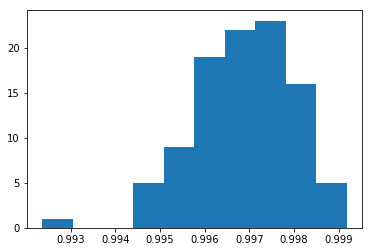

In [91]:
print np.mean(pssn)
plt.hist(pssn);

In [92]:
def PSSnAvg(A,F,L=25.5,wavelength=500e-9,r0=15e-2,L0=25):
    nPx = A.shape[0]
    u = np.arange(2*nPx-1,dtype=np.float)*L/(nPx-1)
    u = u-u[-1]/2
    x,y = np.meshgrid(u,u)
    rho = np.hypot(x,y)
    C = atmOTF(rho,r0,L0)
    D = telOTF(A,0,wavelength)*C
    sD2 = np.sum(np.abs(D)**2)
    if F.ndim<3:
        F = F[...,np.newaxis]
    nF = F.shape[2]
    out = np.zeros(nF)
    telOTFavg = np.zeros((2*nPx-1,2*nPx-1),dtype=np.complex)
    for k in range(nF):
        telOTFavg += telOTF(A,F[:,:,k],wavelength)
    N = telOTFavg*C/nF
    out = np.sum(np.abs(N)**2)/sD2
    return out

In [93]:
PSSnAvg(A,F)

0.99638118989764257

In [ ]:
tt7 = ModelData(None,variate=None)

In [ ]:
tt7.variate

In [ ]:
laco.wfs.spotFWHM_arcsec